In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate

## System of Equations

The equations of structure of an compact object with spherical symmetry (neutron stars in our case) is given by (in units where $c=G=1$):

$$ P=P(\rho), $$
$$ \frac{dm}{dr}=4\pi \rho r^2 , $$
$$ \frac{dP}{dr}=-(\rho+P)\frac{m+4\pi r^3 P}{r(r-2m)} , $$

and if is required


$$ \frac{d\nu}{dr}= \frac{m+4\pi r^3 P}{r(r-2m)} .$$


Nondimensionalizing the variables:


$r=b\bar{r} \quad ; \quad \rho=\Sigma \bar{\rho} \quad ; \quad m=m_*\bar{m} \quad ; \quad  P=P_* \bar{P}$ 

with $\Sigma=\Sigma(m_n)$.

So if we want just one parameter ($m_n$), given $\Sigma$, the other parameters $b$, $m_*$, $P_*$ are found by forcing the nondimensional equation to keep the same form:

$$ b=\frac{1}{\sqrt{\Sigma}} \quad ; \quad m_*=b \quad ; \quad P_*=\Sigma.$$

With a particular choice of $\Sigma$ and fixing the units with factors of $c$ and $G$ we have:


$$ \Sigma=\frac{m_{n}^{4}c^{3}}{8 \pi^2 \hbar^3}\quad;\quad b=\frac{c}{\sqrt{\Sigma G}}\quad, \quad m= \frac{b c^2}{G} \bar{m} \quad; \quad P= \Sigma c^2 \bar{P},$$

and the nondimensional system of equations keeps the same form:

$$ \bar{P}=\bar{P}(\bar{\rho}), $$
$$ \frac{d\bar{m}}{\bar{dr}}=4\pi \bar{\rho} \bar{r}^2 , $$
$$ \frac{d\bar{P}}{d\bar{r}}=-(\bar{\rho}+\bar{P})\frac{\bar{m}+4\pi \bar{r}^3 \bar{P}}{\bar{r}(\bar{r}-2\bar{m})} . $$

## Solving the system

To solve this system of equations we need two initial conditions:

$$ \bar{P}{(0)}=P_{c}{(\bar{\rho_{c}})} \quad ; \quad \bar{m}{(0)}=0,$$

depending on the choice of $\rho_{c}$.

We want our equation of state to be a table of numbers $(\rho_{i},P_{i})$, this equation of state will depend on the theoretical model used to study the interior of the neutron star.

Loading some constants (in cgs units) from a separeted file and declaring the parameters that carry the dimensions

In [2]:
import Physical_Const as phys
h=phys.h 
c=phys.c
G=phys.G
Msun=phys.Msun
mn=phys.mn # Neutron mass


Sigma=mn**4.0*c**3.0/(8.0*np.pi**2*(h/(2.0*np.pi))**3.0) #Dimensions of energy density
b=c/np.sqrt(Sigma*G) # Dimensions of radius
mdim=b*c**2.0/G # Dimensions of mass
pdim=Sigma*c**2 # Dimensions of pressure

loading the equation of state and interpolating it linearly

In [3]:
rhoEoS,PEoS=np.loadtxt('EOSFull_NL3_BPS02.dat',usecols=(0,1),unpack=True) 

# Interpolating P

def P_EoS(r):
    pp=interpolate.interp1d(rhoEoS/Sigma,PEoS/pdim)
    return pp(r)


# Interpolating Rho

def rho_EoS(r):
    rhorho=interpolate.interp1d(PEoS/pdim,rhoEoS/Sigma)
    return rhorho(r)


Comparing the table and the interpolation

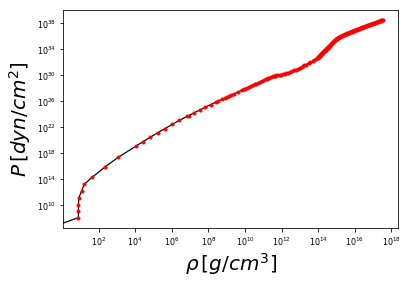

In [4]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.loglog(rhoEoS,P_EoS(rhoEoS/Sigma)*pdim,'k-', \
           linewidth=1.2,label="Interpolation") # Interpolación
plt.loglog(rhoEoS,PEoS,'ro', \
           markersize=3,label='Data') # Valores de la tabla
plt.xlabel(r'$\rho\,[g/cm^3]$')
plt.ylabel(r'$P\,[dyn/cm^{2}]$')
plt.savefig('NL3EoS.png', format='png', dpi=1000)
#plt.savefig('NL3EoS.eps')
plt.show()
plt.clf()

With the equation of state interpolated we can declare the system of equations:

In [9]:
def TOV(r,y):
    mns, pns, nuns = y
    print(pns*pdim,rho_EoS(pns)*Sigma)
    dmdr=4.0*np.pi*r**2.0*rho_EoS(pns)
    dnudr=(4.0*np.pi*r**3.0*pns+mns)/(r*(r-2.0*mns))
    dpdr=-dnudr*(pns+rho_EoS(pns))
    return [dmdr,dpdr,dnudr]

# Stellar structure

Setting up the integration routine

In [16]:
def StaticSeq(y0,r0,dr):
    """  """
    Static=integrate.ode(TOV).set_integrator('dopri5',atol=1e-9) # Dopri (Dorman-Prince method) is a R-K method of order (4)5
    Static.set_initial_value(y0,r0)
    ms=[]; ps=[];rs=[]; rhos=[]
    ms.append(y0[0]*mdim/Msun); ps.append(y0[1]*pdim); rhos.append(rho_EoS(y0[1])*Sigma); rs.append(r0*b*1e-5) 
    while Static.successful() and rho_EoS(Static.y[1])*Sigma>1e+8 and Static.y[1]>0: 
        print(Static.y[1]*pdim,rho_EoS(Static.y[1])*Sigma,'H')
        Static.integrate(Static.t+dr)
        ms.append(Static.y[0]*mdim/Msun); ps.append(Static.y[1]*pdim); rhos.append(rho_EoS(Static.y[1])*Sigma); rs.append(Static.t*b*1e-5)  
    return [ms,ps,rhos,rs] 
    # Returns arrays of m(r) in solar masses, P(r) and Rho(r) in cgs, and r in km

## Stability against adiabatic convection

The density profile should satisfy $\rho^{\prime\prime}(r) \leq 0 $.

In [17]:
pdim

2.0499091631194222e+36

In [18]:
rho_0=10**15
P_0=P_EoS(rho_0/Sigma)

m1,p1,rho1,r1=StaticSeq([0,P_0,0],1e-2,1e-4)

3.39182108639234e+35 1000000000000000.0 H
3.39182108639234e+35 1000000000000000.0
3.3917953464939964e+35 999996157473195.8
3.3918159384126715e+35 999999231494639.1
3.391813322271757e+35 999998840949523.0
3.391800194006421e+35 999996881123933.5
3.39179783380183e+35 999996528785735.2
3.391794876130541e+35 999996087255972.8
3.391794879040869e+35 999996087690434.9
3.391794879040869e+35 999996087690434.9 H
3.391794879040869e+35 999996087690434.9
3.391789544525925e+35 999995291338546.2
3.3917868357164705e+35 999994886959601.4
3.3917732447602946e+35 999992858062179.1
3.3917708026594835e+35 999992493498275.2
3.391767742733266e+35 999992036703599.6
3.39176774561537e+35 999992037133848.5
3.39176774561537e+35 999992037133848.5 H
3.39176774561537e+35 999992037133848.5
3.3917622271888055e+35 999991213327099.0
3.391759426999433e+35 999990795306694.4
3.391745379770812e+35 999988698295595.9
3.39174285690134e+35 999988321674311.6
3.391739696124662e+35 999987849824386.5
3.391739698979069e+35 99998785025

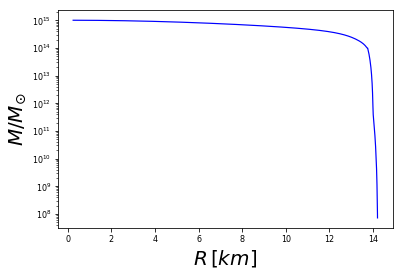

In [19]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(r1,rho1,'b-', linewidth=1.2) 
plt.yscale('log')
plt.xlabel(r'$R\,[km]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.savefig('DProf_NL3.png', format='png', dpi=1000)
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()

## M-R and M-$\rho_c$

The same integration routine (without saving the arrays)

In [57]:
def StaticSeqMR(y0,r0,dr):
    Static=integrate.ode(TOV).set_integrator('dop853',atol=1e-9) # Dopri (Dorman-Prince method) is a R-K method of order (4)5
    Static.set_initial_value(y0,r0)
    while Static.successful() and rho_EoS(Static.y[1])*Sigma>1e+6 and Static.y[1]>0:
        Static.integrate(Static.t+dr)
    mstar=Static.y[0]
    rstar=Static.t
    nustar=np.log(1-2.0*Static.y[0]/Static.t)-Static.y[2]  
    return [mstar*mdim/Msun,rstar*b*1e-5,rho_EoS(y0[1])*Sigma] 
    # Returns mass of the star in solar masses, radius of the star in km and rho_c in cgs

We choose the values for $\rho_c$ we want to consider and integrate from $r0$ every $dr$ saving the different values of $M_{star}$, $R_{star}$ and $\rho_c$ (slow):

In [58]:
#Range of central densities and central pressures
n=np.arange(14.1,16,0.05)
rhosc=10.0**n 
psc=P_EoS(rhosc/Sigma) 

In [59]:
#Initial values
dr=1e-4 # Step size
r0=dr/1000.0 # Initial point
m0=0 
nu0=0

In [51]:
StaticSeqMR([m0,psc[0],nu0],r0,dr)

[0.12532789012940504, 34.915385471445774, 125892541179416.62]

In [60]:
MM=[];RR=[];rhorho=[]

for pc in psc:
    MRrho=StaticSeqMR([m0,pc,nu0],r0,dr)
   # print(MRrho)
    RR=RR+[MRrho[1]]
    MM=MM+[MRrho[0]]
    rhorho=rhorho+[MRrho[2]]

KeyboardInterrupt: 

### Mass-Radius Relation

Plotting the M-R relation

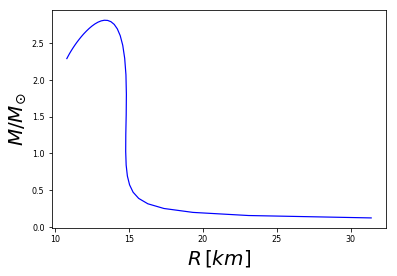

In [55]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(RR, MM,'b-', linewidth=1.2) 
plt.xlabel(r'$R\,[km]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.savefig('MRrel_NL3.png', format='png', dpi=1000)
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()

### Mass-Central Density Relation

Plotting the M-$\rho_c$ relation

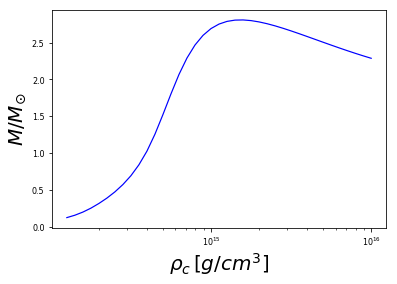

In [56]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(rhorho, MM,'b-', linewidth=1.2)
plt.xscale('log')
plt.xlabel(r'$\rho_c\,[g/cm^{3}]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.savefig('Mrhorel_NL3.png', format='png', dpi=1000)
#plt.savefig('MRrhorel_NL3.eps')
plt.show()
plt.clf()